In [1]:
from catinous.dataset import BatchDataset, ContinuousDataset
from catinous.dynamicmemory.DynamicMemoryModel import DynamicMemoryModel 
import catinous.dynamicmemory.DynamicMemoryModel as dmodel
import catinous.utils as cutils
import os
import pandas as pd
from py_jotools import mut, slurm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
#import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from catinous.dataset.ContinuousDataset import *
from catinous.dataset.BatchDataset import *
from torch.utils.data import DataLoader
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import catinous.evalfunctions as evalfu
import pydicom as pyd

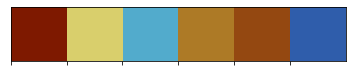

In [2]:
mapname = 'roma'

cm_data = np.loadtxt(f"/home/mperkonigg/Documents/ScientificColourMaps6/{mapname}/{mapname}.txt")
#colormap = LinearSegmentedColormap.from_list('scientific_cm', cm_data)
#x = np.linspace(0, 100, 25)[None, :]
#plt.imshow(x, aspect='auto',cmap=colormap)
#plt.axis('off')
#plt.show()
colormap = ListedColormap([cm_data[0], cm_data[85],cm_data[180], cm_data[45], cm_data[20], cm_data[227]], name='scientific_cm')
matplotlib.cm.register_cmap(cmap=colormap, name='scientific_cm')
sns.set_palette('scientific_cm')
sns.palplot(sns.color_palette())

In [ ]:
def ap_model(hparams, split='test'):
    recalls = {'ges': [], 'geb': [], 'sie': [], 'time_siemens': []}
    precision = {'ges': [], 'geb': [], 'sie': [], 'time_siemens': []}
    device = torch.device('cuda')

    
    model, logs, df_mem, expname = dmodel.trained_model(hparams, training=False)
    model.to(device)
    model.eval()

    for res in ['ges', 'geb', 'sie', 'time_siemens']:
        ds_test = LIDCBatch('/project/catinous/lungnodulesfinal.csv', 
                      cropped_to=(288, 288), split=[split], res=res, validation=True)

        iou_thres = 0.4

        overall_true_pos = dict()
        overall_false_pos = dict()
        overall_false_neg = dict()
        overall_boxes_count = dict()
        for k in np.arange(0.0, 1.01, 0.05):
            overall_true_pos[k] = 0
            overall_false_pos[k] = 0
            overall_false_neg[k] = 0
            overall_boxes_count[k] = 0
            

        for batch in ds_test:
            img_batch, annot, res, image = batch
            img_batch = img_batch[None, :, :, :]
            img_batch = img_batch.to(device)

            out = model.model(img_batch)
            out_boxes = [cutils.filter_boxes_area(out[i]['boxes'].cpu().detach().numpy(), out[i]['scores'].cpu().detach().numpy()) for i in range(len(out))]
            boxes_np = [b[0] for b in out_boxes]
            scores_np = [b[1] for b in out_boxes]

            final_boxes, final_scores = cutils.correct_boxes(boxes_np[0], scores_np[0])

            gt = annot['boxes']
            for k in np.arange(0.0, 1.01, 0.05):
                false_positives = 0
                false_negatives = 0
                true_positives = 0
                detected = False
                boxes_count = 0
                if len(final_boxes)>0:
                    for i, b in enumerate(final_boxes):
                        if final_scores[i]>k:
                            boxes_count += 1
                            detected_gt = False
                            for g in gt:
                                if cutils.bb_intersection_over_union(g, b)>iou_thres:
                                    detected = True
                                    detected_gt = True
                            if not detected_gt:
                                false_positives += 1
                    if detected:
                        true_positives += 1
                    else:
                        false_negatives += 1
                overall_true_pos[k] += true_positives
                overall_false_pos[k] += false_positives
                overall_false_neg[k] += false_negatives
                overall_boxes_count[k] += boxes_count
        for k in np.arange(0.0, 1.01, 0.05):
            if (overall_false_neg[k]+overall_true_pos[k])==0:
                recalls[res].append(0.0)
            else:
                recalls[res].append(overall_true_pos[k]/(overall_false_neg[k]+overall_true_pos[k]))
            if (overall_false_pos[k]+overall_true_pos[k])==0:
                precision[res].append(0.0)
            else:
                precision[res].append(overall_true_pos[k]/(overall_false_pos[k]+overall_true_pos[k]))
    return recalls, precision

def get_ap_for_res(hparams, split='test'):
    recalls, precisions = ap_model(hparams, split)
    
    aps = dict()
    for res in ['ges', 'geb', 'sie', 'time_siemens']:
        prec = np.array(precisions[res])
        rec = np.array(recalls[res])
        ap = []
        for t in np.arange(0.0, 1.01, 0.1):
            prec_arr = prec[rec>t]
            if len(prec_arr)==0:
                ap.append(0.0)
            else:
                ap.append(prec_arr.max())
        aps[res] = np.array(ap).mean()
    return aps

In [6]:
hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/lungnodulesfinalpatientsplit.csv',
         'batch_size': 8,
         'training_batch_size': 8,
         'transition_phase_after':0.8,
         'memorymaximum': 64,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
        'order': ['ges', 'geb', 'sie', 'time_siemens'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'lidc_batch_lungnodulesfinalpatientsplit_base_1_4e9eb3ca65.pt', 
         'run_postfix': 1,
        'dim': 2,
         'task': 'lidc',
         'model': 'rnn',
         'seed': 1654130,
         'stylemodel': True,
         'gram_weights': [1, 1],
         #'pseudodomain_detection': True
        }

hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)
aps = get_ap_for_res(hparams, split='val')

expname lidc_cont_lungnodulesfinalpatientsplit_basemodel_batch_mem_tf08_1_64dc79fc9e
Read: /project/catinous/trained_models/lidc_cont_lungnodulesfinalpatientsplit_basemodel_batch_mem_tf08_1_64dc79fc9e.pt


In [5]:
#test
aps

{'ges': 0.7675628552498519,
 'geb': 0.49007974481658695,
 'sie': 0.6233766233766234,
 'time_siemens': 0.1405334861217214}

In [7]:
#val
aps

{'ges': 0.8492360371455931,
 'geb': 0.7181883772792863,
 'sie': 0.5938934802571166,
 'time_siemens': 0.20903525158844305}

In [9]:
hparams = {
    'continuous': False,
    'datasetfile': '/project/catinous/lungnodulesfinalpatientsplit.csv',
    'batch_size': 8,
    'training_batch_size': 8,
    'task': 'lidc',
    'model': 'rnn',
    'scanner': 'ges',
    'val_check_interval': 50,
     'noncontinuous_steps': 1000,
    'noncontinuous_train_splits': ['base'],
    'order': ['ges', 'geb', 'sie', 'time_siemens'],
    'use_memory': False
}



hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)
aps = get_ap_for_res(hparams)

lidc_batch_lungnodulesfinalpatientsplit_base_1_4e9eb3ca65
Read: /project/catinous/trained_models/lidc_batch_lungnodulesfinalpatientsplit_base_1_4e9eb3ca65.pt


In [10]:
aps

{'ges': 0.7944284768055261,
 'geb': 0.5943468296409473,
 'sie': 0.8780594405594406,
 'time_siemens': 0.21996451183054055}

In [3]:
hparams = {'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/lungnodulesfinalpatientsplit.csv',
         'batch_size': 4,
         'training_batch_size': 8,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': True,
        'order': ['ges', 'geb', 'sie', 'time_siemens'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'lidc_batch_lungnodulesfinalpatientsplit_base_1_4e9eb3ca65.pt', 
         'run_postfix': 1,
        'dim': 2,
         'task': 'lidc',
         'model': 'rnn',
         'seed': 1654130,
         'stylemodel': True,
         'gram_weights': [1, 1],
         'force_misclassified': True,
         'misclass_threshold': 0,
         'pseudodomain_detection': True
        }

seeds = [1654130, 6654961, 5819225, 1215862, 132054]

hparams['seed'] = seeds[0]
hparams['run_postfix'] = 1
model, logs, df_cache, basemodel_lr = dmodel.trained_model(hparams, training=False)

expname lidc_cont_lungnodulesfinalpatientsplit_basemodel_batch_mem_tf08_1_5ec40ddbfc
Read: /project/catinous/trained_models/lidc_cont_lungnodulesfinalpatientsplit_basemodel_batch_mem_tf08_1_5ec40ddbfc.pt


In [35]:
dl_val = DataLoader(LIDCBatch('/project/catinous/lungnodulesfinalpatientsplit.csv',
                                      split='test', res='time_siemens', validation=True),
                      batch_size=8,
                      num_workers=2,
                      collate_fn=cutils.collate_fn,
                       shuffle=True)

In [36]:
device = torch.device('cuda')
model.to(device)
model.eval()

for batch in dl_val:
    x, y, scanner, filepath = batch
    x = list(i.to(device) for i in x)
    #targets = [{k: v.to(self.device) for k, v in t.items()} for t in y]
    
    out = model.forward(x)
    break    

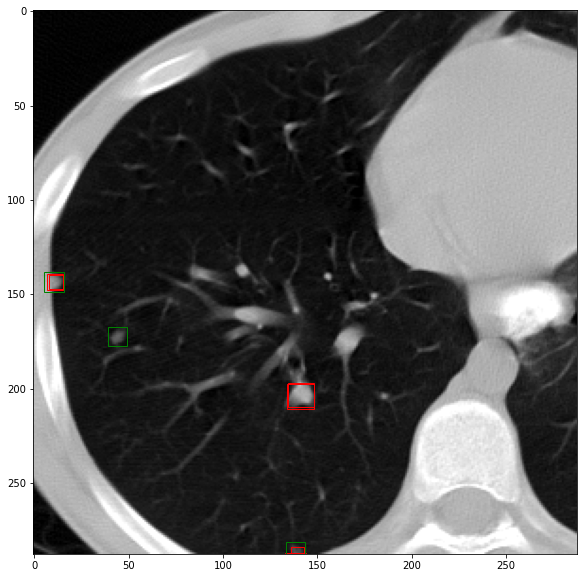

In [45]:
idx = 7

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

xywh = [[ab[0], ab[1], ab[2] - ab[0], ab[3] - ab[1]] for ab in out[idx]['boxes']]

ax.imshow(x[idx].detach().cpu().numpy()[0])
#plt.scatter([x], [y])
for k, xy in enumerate(xywh):
    rect = patches.Rectangle((xy[0],xy[1]),xy[2],xy[3],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
for gt in y[idx]['boxes']:
    rect = patches.Rectangle((gt[0], gt[1]), gt[2] - gt[0], gt[3] - gt[1], edgecolor='g', facecolor='none')
    ax.add_patch(rect)

In [69]:
filepath[7]

'/data/dataset/lung/LIDC/DICOMS/LIDC-IDRI/LIDC-IDRI-0473/01-01-2000-CT CHEST O CONTR-56991/51777/000229.dcm'

In [73]:
df_dataset

,dataset,scanner,patient_id,image,x1,x2,y1,y2,bin_malignancy,split
0,lidc,ges,LIDC-IDRI-0001,/data/dataset/lung/LIDC/DICOMS/LIDC-IDRI/LIDC-...,300.000000,333.000000,351.000000,384.000000,1,base
1,lidc,ges,LIDC-IDRI-0003,/data/dataset/lung/LIDC/DICOMS/LIDC-IDRI/LIDC-...,354.000000,380.000000,337.000000,363.000000,0,val
2,lidc,ges,LIDC-IDRI-0003,/data/dataset/lung/LIDC/DICOMS/LIDC-IDRI/LIDC-...,303.000000,313.000000,193.000000,203.000000,1,val
3,lidc,ges,LIDC-IDRI-0003,/data/dataset/lung/LIDC/DICOMS/LIDC-IDRI/LIDC-...,214.000000,229.000000,212.000000,227.000000,1,val
4,lidc,ges,LIDC-IDRI-0004,/data/dataset/lung/LIDC/DICOMS/LIDC-IDRI/LIDC-...,140.000000,145.000000,321.000000,326.000000,0,test
...,...,...,...,...,...,...,...,...,...,...
1222,time,time_siemens,PND149,/data/dataset/external/LungTIME/PND149/1/49_1_...,375.926450,385.926450,367.749782,377.749782,1,train
1223,time,time_siemens,PND149,/data/dataset/external/LungTIME/PND149/2/49_2_...,52.745840,63.745840,201.318408,212.318408,1,train
1224,time,time_siemens,PND149,/data/dataset/external/LungTIME/PND149/2/49_2_...,424.721968,435.721968,354.952224,365.952224,1,train
1225,time,time_siemens,PND149,/data/dataset/external/LungTIME/PND149/2/49_2_...,448.862736,459.862736,286.401864,297.401864,1,train


In [74]:
df_dataset = pd.read_csv('/project/catinous/lungnodulesfinalpatientsplit.csv')
df_dataset.loc[df_dataset.image.str.startswith('/data/dataset/lung/LIDC/DICOMS/LIDC-IDRI/LIDC-IDRI-0473/')]

,dataset,scanner,patient_id,image,x1,x2,y1,y2,bin_malignancy,split
589,lidc,geb,LIDC-IDRI-0473,/data/dataset/lung/LIDC/DICOMS/LIDC-IDRI/LIDC-...,39.0,45.0,218.0,224.0,0,train
590,lidc,geb,LIDC-IDRI-0473,/data/dataset/lung/LIDC/DICOMS/LIDC-IDRI/LIDC-...,111.0,116.0,164.0,169.0,0,train
591,lidc,geb,LIDC-IDRI-0473,/data/dataset/lung/LIDC/DICOMS/LIDC-IDRI/LIDC-...,190.0,195.0,332.0,337.0,0,train


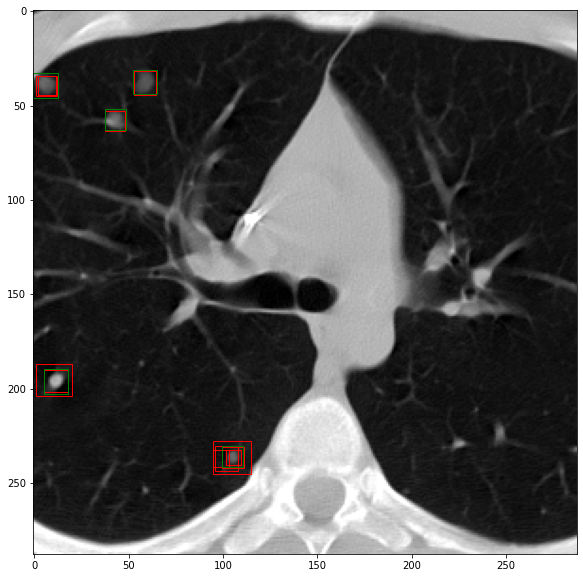

In [8]:
idx = 5

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

xywh = [[ab[0], ab[1], ab[2] - ab[0], ab[3] - ab[1]] for ab in out[idx]['boxes']]

ax.imshow(x[idx].detach().cpu().numpy()[0])
#plt.scatter([x], [y])
for k, xy in enumerate(xywh):
    rect = patches.Rectangle((xy[0],xy[1]),xy[2],xy[3],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
for gt in y[idx]['boxes']:
    rect = patches.Rectangle((gt[0], gt[1]), gt[2] - gt[0], gt[3] - gt[1], edgecolor='g', facecolor='none')
    ax.add_patch(rect)

In [36]:
def res_data_for_params(hparams, seeds=None):
    df = pd.DataFrame()
    hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)
    if seeds is None:        
        exp_name = cutils.get_expname(hparams)

        max_version = max([int(x.split('_')[1]) for x in os.listdir(cutils.LOGGING_FOLDER + exp_name)])
        df_temp = pd.read_csv(cutils.LOGGING_FOLDER + exp_name + '/version_{}/metrics.csv'.format(max_version))

        df_temp = df_temp.loc[df_temp['val_ap_geb']==df_temp['val_ap_geb']]
        df_temp['idx'] = range(1,len(df_temp)+1)
        df = df.append(df_temp)
    else:
        for i, seed in enumerate(seeds):
            hparams['seed'] = seed
            hparams['run_postfix'] = i+1
            exp_name = cutils.get_expname(hparams)
            max_version = max([int(x.split('_')[1]) for x in os.listdir(cutils.LOGGING_FOLDER + exp_name)])
            df_temp = pd.read_csv(cutils.LOGGING_FOLDER + exp_name + '/version_{}/metrics.csv'.format(max_version))

            df_temp = df_temp.loc[df_temp['val_ap_geb']==df_temp['val_ap_geb']]
            df_temp['idx'] = range(1,len(df_temp)+1)
            df = df.append(df_temp)
    #if os.path.exists(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv'):
    #    df_mem = pd.read_csv(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv')
    #else:
    #    print(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv', 'not existing')
    #    df_mem = None

    return df#, df_mem

ds = LIDCContinuous('/project/catinous/lungnodulesfinalpatientsplit.csv', seed=1654130)
res = ds.df.scanner == 'ges'
res1 = ds.df.scanner == 'geb'
res2 = ds.df.scanner == 'sie'
res3 = ds.df.scanner == 'time_siemens'
res[res1] = 2
res[res2] = 3
res[res3] = 4

In [6]:
hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/lungnodulesfinalpatientsplit.csv',
         'batch_size': 4,
         'training_batch_size': 8,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': True,
        'order': ['ges', 'geb', 'sie', 'time_siemens'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'lidc_batch_lungnodulesfinalpatientsplit_base_1_4e9eb3ca65.pt', 
         'run_postfix': 1,
        'dim': 2,
         'task': 'lidc',
         'model': 'rnn',
         'seed': 1654130,
         'stylemodel': True,
         'gram_weights': [1, 1],
         'force_misclassified': True,
         'misclass_threshold': 0,
         'pseudodomain_detection': True
        }

seeds = [1654130, 6654961, 5819225, 1215862, 132054]
df = res_data_for_params(hparams, seeds=seeds)

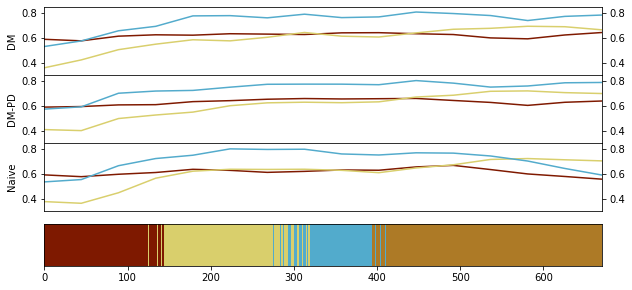

In [44]:
val_measure = 'val_ap'
fig, axes = plt.subplots(4, 1, figsize=(10, 5))
plt.subplots_adjust(hspace=0.0)

hparams_set = [hparams_128_DM, hparams_128_PD, hparams_naive]
names = ['DM', 'DM-PD', 'Naive']
for k, hparams in enumerate(hparams_set):

    df = res_data_for_params(hparams, seeds=seeds)

    ax = axes[k]
    for scanner in hparams['order']:
        sns.lineplot(data=df, y=f'{val_measure}_{scanner}', x='idx', err_style=None, ax=ax, label=scanner)
    ax.set_ylim(0.3, 0.85)
    ax.get_xaxis().set_visible(False)
    ax.get_legend().remove()
    ax.set_xlim(1, 16)
    ax.set_ylabel(names[k])
    ax.tick_params(labelright=True, right=True)



axes[3].imshow(np.tile(res,(50,1)), cmap=ListedColormap(colormap.colors[:4]))
axes[3].get_yaxis().set_visible(False)
axes[3].get_yaxis()
plt.savefig(cutils.RESPATH + f'lidc/lidc_validationcurves.pdf')

In [38]:
df

,created_at,epoch,train_loss,val_ap_geb,val_ap_ges,val_ap_sie,val_ap_time_siemens,idx
0,2021-01-26 07:37:17.278986,NaN,NaN,0.384026,0.605346,0.525974,0.007576,1
1,2021-01-26 07:37:29.027832,NaN,NaN,0.492120,0.623613,0.652237,0.011364,2
2,2021-01-26 07:37:40.952553,NaN,NaN,0.401731,0.591235,0.642857,0.011364,3
3,2021-01-26 07:37:54.315377,NaN,NaN,0.440617,0.562041,0.617483,0.019697,4
5,2021-01-26 07:38:06.633787,NaN,NaN,0.536779,0.623755,0.730387,0.036168,5
...,...,...,...,...,...,...,...,...
13,2021-01-26 07:53:46.373715,NaN,NaN,0.641831,0.671157,0.788706,0.043607,12
14,2021-01-26 07:53:58.201352,NaN,NaN,0.710722,0.652592,0.794805,0.038095,13
15,2021-01-26 07:54:09.212471,NaN,NaN,0.727007,0.610916,0.811639,0.035714,14
17,2021-01-26 07:54:20.251198,NaN,NaN,0.697033,0.595600,0.707071,0.035266,15


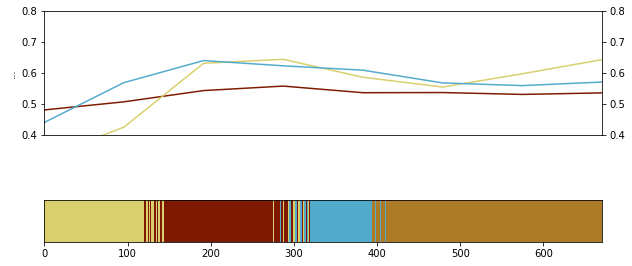

In [85]:
val_measure = 'val_ap'
fig, axes = plt.subplots(2, 1, figsize=(10, 5))

df = res_data_for_params(hparams, seeds=seeds)

ax = axes[0]
for scanner in hparams['order']:
    sns.lineplot(data=df, y=f'{val_measure}_{scanner}', x='idx', err_style=None, ax=ax, label=scanner)
ax.set_ylim(0.4, 0.8)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 8)
ax.set_ylabel(f'...')
ax.tick_params(labelright=True, right=True)



axes[1].imshow(np.tile(res,(50,1)), cmap=ListedColormap(colormap.colors[:4]))
axes[1].get_yaxis().set_visible(False)
axes[1].get_yaxis()

In [9]:
df

,created_at,epoch,train_loss,val_ap_geb,val_ap_ges,val_ap_sie,val_ap_time_siemens,idx
0,2021-01-20 08:08:13.928641,NaN,NaN,0.451054,0.633568,0.642267,0.003367,1
1,2021-01-20 08:08:31.471669,NaN,NaN,0.556467,0.634738,0.675000,0.005682,2
2,2021-01-20 08:08:48.916040,NaN,NaN,0.477148,0.630016,0.622231,0.017325,3
3,2021-01-20 08:09:07.421614,NaN,NaN,0.503206,0.646472,0.719449,0.019192,4
5,2021-01-20 08:09:26.652889,NaN,NaN,0.528253,0.650216,0.715909,0.025974,5
6,2021-01-20 08:09:46.876640,NaN,NaN,0.554829,0.664432,0.705571,0.029091,6
7,2021-01-20 08:10:03.931785,NaN,NaN,0.491225,0.654030,0.656707,0.029091,7
8,2021-01-20 08:10:20.276449,NaN,NaN,0.543786,0.656135,0.708081,0.034632,8
0,2021-01-20 08:28:30.846783,NaN,NaN,0.333129,0.597412,0.474231,0.005865,1
1,2021-01-20 08:28:50.459224,NaN,NaN,0.483649,0.624682,0.709382,0.012987,2


In [4]:
df_overall = pd.DataFrame()

In [ ]:
df_overview = df_overall.groupby(['model', 'scanner']).mean().reset_index()
df_overview.pivot(index='model', columns='scanner', values='mean').round(3)

In [46]:
seeds = [1654130, 6654961, 5819225, 1215862, 132054]

hparams_naive = {'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/lungnodulesfinalpatientsplit.csv',
         'batch_size': 4,
         'training_batch_size': 8,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':False,
         'random_memory': True,
         'balance_memory': False,
        'order': ['ges', 'geb', 'sie', 'time_siemens'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'lidc_batch_lungnodulesfinalpatientsplit_base_1_4e9eb3ca65.pt', 
         'run_postfix': 1,
        'dim': 2,
         'task': 'lidc',
         'model': 'rnn',
         'seed': 1654130
        }


hparams_128_PD = {'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/lungnodulesfinalpatientsplit.csv',
         'batch_size': 4,
         'training_batch_size': 8,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': True,
        'order': ['ges', 'geb', 'sie', 'time_siemens'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'lidc_batch_lungnodulesfinalpatientsplit_base_1_4e9eb3ca65.pt', 
         'run_postfix': 1,
        'dim': 2,
         'task': 'lidc',
         'model': 'rnn',
         'seed': 1654130,
         'stylemodel': True,
         'gram_weights': [1, 1],
         'force_misclassified': True,
         'misclass_threshold': 0,
         'pseudodomain_detection': True
        }

hparams_64_PD = {'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/lungnodulesfinalpatientsplit.csv',
         'batch_size': 4,
         'training_batch_size': 8,
         'transition_phase_after':0.8,
         'memorymaximum': 64,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': True,
        'order': ['ges', 'geb', 'sie', 'time_siemens'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'lidc_batch_lungnodulesfinalpatientsplit_base_1_4e9eb3ca65.pt', 
         'run_postfix': 1,
        'dim': 2,
         'task': 'lidc',
         'model': 'rnn',
         'seed': 1654130,
         'stylemodel': True,
         'gram_weights': [1, 1],
         'force_misclassified': True,
         'misclass_threshold': 0,
         'pseudodomain_detection': True
        }

hparams_64_DM = {'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/lungnodulesfinalpatientsplit.csv',
         'batch_size': 4,
         'training_batch_size': 8,
         'transition_phase_after':0.8,
         'memorymaximum': 64,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
        'order': ['ges', 'geb', 'sie', 'time_siemens'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'lidc_batch_lungnodulesfinalpatientsplit_base_1_4e9eb3ca65.pt', 
         'run_postfix': 1,
        'dim': 2,
         'task': 'lidc',
         'model': 'rnn',
         'seed': 1654130,
         'stylemodel': True,
         'gram_weights': [1, 1],
         'force_misclassified': True,
         'misclass_threshold': 0
        }

hparams_128_DM = {'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/lungnodulesfinalpatientsplit.csv',
         'batch_size': 4,
         'training_batch_size': 8,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
        'order': ['ges', 'geb', 'sie', 'time_siemens'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'lidc_batch_lungnodulesfinalpatientsplit_base_1_4e9eb3ca65.pt', 
         'run_postfix': 1,
        'dim': 2,
         'task': 'lidc',
         'model': 'rnn',
         'seed': 1654130,
         'stylemodel': True,
         'gram_weights': [1, 1],
         'force_misclassified': True,
         'misclass_threshold': 0
        }

In [28]:



hparams_set = [hparams_naive, hparams_128_DM, hparams_128_PD, hparams_64_DM, hparams_64_PD]

names = ['Naive', '128 DM', '128 PD', '64 DM', '64 PD']

#hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)

df_overall = pd.DataFrame()

for k, hparams in enumerate(hparams_set):
    print(names[k])
    df_res = pd.read_csv(f'/project/catinous/results/lidc/{cutils.get_expname(hparams)}_meanaverageprecision.csv')
    for seed in seeds:
        df_bwt_fwt = df_res.loc[df_res.seed==seed].reset_index(drop=True)

        order = ['ges', 'geb', 'sie', 'time_siemens']
        bwt = 0.0
        fwt = 0.0

        for i in range(len(order)-1):
            bwt += df_bwt_fwt.loc[df_bwt_fwt['shift']=='None'][order[i]].values[0] - df_bwt_fwt.loc[df_bwt_fwt['shift']==order[i+1]][order[i]].values[0]

        order = ['ges', 'geb', 'sie', 'time_siemens', 'None']

        for i in range(2, len(order)):
            fwt += df_bwt_fwt.loc[df_bwt_fwt['shift']==order[i]][order[i-1]].values[0] - df_bwt_fwt.loc[df_bwt_fwt['shift']==order[1]][order[i-1]].values[0]

        bwt /= len(order)-1
        fwt /= len(order)-1
        df_res = df_res.append(pd.DataFrame({'shift':['BWT', 'FWT'], 
                                    'ges':[bwt, fwt], 
                                    'geb':[0, 0], 
                                    'sie':[0, 0],
                                    'time_siemens':[0, 0]}))

    df_res['name'] = names[k]

    df_overall = df_overall.append(df_res)

Naive
128 DM
128 PD
64 DM
64 PD


In [33]:
df_overall.groupby(['shift', 'name']).std().round(3)[['ges', 'geb', 'sie', 'time_siemens']]

ges    geb    sie  time_siemens
shift        name                                     
BWT          128 DM  0.019  0.000  0.000         0.000
             128 PD  0.025  0.000  0.000         0.000
             64 DM   0.014  0.000  0.000         0.000
             64 PD   0.020  0.000  0.000         0.000
             Naive   0.018  0.000  0.000         0.000
FWT          128 DM  0.018  0.000  0.000         0.000
             128 PD  0.012  0.000  0.000         0.000
             64 DM   0.012  0.000  0.000         0.000
             64 PD   0.033  0.000  0.000         0.000
             Naive   0.023  0.000  0.000         0.000
None         128 DM  0.018  0.043  0.037         0.029
             128 PD  0.032  0.018  0.046         0.053
             64 DM   0.027  0.015  0.030         0.016
             64 PD   0.018  0.053  0.042         0.035
             Naive   0.044  0.016  0.042         0.019
geb          128 DM  0.013  0.021  0.020         0.026
             128 PD  0.011  0.021  0.029         0.018
             64 DM   0.022  0.036  0.032         0.028
             64 PD   0.024  0.061  0.062         0.043
             Naive   0.022  0.017  0.056         0.019
sie          128 DM  0.022  0.055  0.026         0.041
             128 PD  0.017  0.055  0.018         0.018
             64 DM   0.014  0.074  0.026         0.023
             64 PD   0.013  0.027  0.049         0.030
             Naive   0.019  0.043  0.022         0.021
time_siemens 128 DM  0.015  0.064  0.031         0.046
             128 PD  0.014  0.022  0.033         0.018
             64 DM   0.022  0.049  0.025         0.033
             64 PD   0.016  0.066  0.036         0.022
             Naive   0.022  0.037  0.023         0.025

In [11]:
df_res.groupby('shift').mean().round(3)

,geb,ges,sie,time_siemens,seed
shift,,,,,
BWT,0.000,0.038,0.000,0.000,NaN
FWT,0.000,0.042,0.000,0.000,NaN
None,0.519,0.691,0.703,0.269,3095246.4
geb,0.259,0.674,0.706,0.221,3095246.4
sie,0.379,0.689,0.729,0.261,3095246.4
time_siemens,0.401,0.704,0.708,0.250,3095246.4


In [12]:
df_res.groupby('shift').std().round(3)

,geb,ges,sie,time_siemens,seed
shift,,,,,
BWT,0.000,0.025,0.000,0.000,NaN
FWT,0.000,0.012,0.000,0.000,NaN
None,0.018,0.032,0.046,0.053,2936027.88
geb,0.021,0.011,0.029,0.018,2936027.88
sie,0.055,0.017,0.018,0.018,2936027.88
time_siemens,0.022,0.014,0.033,0.018,2936027.88


In [35]:
hparams = {
    'continuous': False,
    'datasetfile': '/project/catinous/lungnodulesfinalpatientsplit.csv',
    'batch_size': 8,
    'training_batch_size': 8,
    'task': 'lidc',
    'model': 'rnn',
    'scanner': None,
     'noncontinuous_steps': 5000,
    'noncontinuous_train_splits': ['base', 'train'],
    'order': ['ges', 'geb', 'sie', 'time_siemens'],
    'use_memory': False,
    'val_check_interval': 50
}

df_base = pd.DataFrame()
for scanner in [None, 'ges', 'geb', 'sie', 'time_siemens']:
    hparams['scanner'] = scanner
    aps = evalfu.get_ap_for_res(hparams, split='test')
    aps['scanner'] = scanner
    df_base = df_base.append(aps)

expname lidc_batch_lungnodulesfinalpatientsplit_base-train_1_ea03d7c711
Read: /project/catinous/trained_models/lidc_batch_lungnodulesfinalpatientsplit_base-train_1_ea03d7c711.pt


KeyboardInterrupt: 

In [8]:
df_base

,ges,geb,sie,time_siemens,scanner
0,0.635803,0.474892,0.705062,0.088436,None
0,0.715713,0.562492,0.710483,0.119304,ges
0,0.679698,0.572404,0.747344,0.221173,geb
0,0.759938,0.667521,0.758838,0.161504,sie
0,0.640198,0.433477,0.642496,0.290319,time_siemens


In [13]:
ds = LIDCContinuous('/project/catinous/lungnodulesfinalpatientsplit.csv', seed=1654130)
res = ds.df.scanner == 'ges'
res1 = ds.df.scanner == 'geb'
res2 = ds.df.scanner == 'sie'
res3 = ds.df.scanner == 'time_siemens'
res[res1] = 2
res[res2] = 3
res[res3] = 4

In [12]:
ds.df.loc[ds.df.scanner=='ges'].index.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 122, 123, 124, 126, 127, 129, 130, 131, 133,
       135, 137, 138, 139, 142, 143])

In [ ]:
ds.df.loc[ds.df.scanner=='ges'].index.values

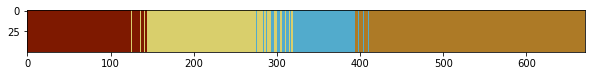

In [14]:
plt.figure(figsize=(10, 5))
plt.imshow(np.tile(res,(50,1)), cmap=ListedColormap(colormap.colors[:4]))


In [10]:
ds.df.loc[ds.df.scanner=='ges']

,dataset,scanner,patient_id,image,x1,x2,y1,y2,bin_malignancy,split
0,lidc,ges,LIDC-IDRI-0399,/data/dataset/lung/LIDC/DICOMS/LIDC-IDRI/LIDC-...,171.0,179.0,154.0,162.0,0,train
1,lidc,ges,LIDC-IDRI-0046,/data/dataset/lung/LIDC/DICOMS/LIDC-IDRI/LIDC-...,426.0,433.0,327.0,334.0,0,train
2,lidc,ges,LIDC-IDRI-0722,/data/dataset/lung/LIDC/DICOMS/LIDC-IDRI/LIDC-...,395.0,405.0,262.0,272.0,1,train
3,lidc,ges,LIDC-IDRI-0947,/data/dataset/lung/LIDC/DICOMS/LIDC-IDRI/LIDC-...,95.0,105.0,265.0,275.0,1,train
4,lidc,ges,LIDC-IDRI-0187,/data/dataset/lung/LIDC/DICOMS/LIDC-IDRI/LIDC-...,342.0,366.0,267.0,291.0,1,train
...,...,...,...,...,...,...,...,...,...,...
137,lidc,ges,LIDC-IDRI-0158,/data/dataset/lung/LIDC/DICOMS/LIDC-IDRI/LIDC-...,280.0,287.0,289.0,296.0,1,train
138,lidc,ges,LIDC-IDRI-0055,/data/dataset/lung/LIDC/DICOMS/LIDC-IDRI/LIDC-...,341.0,352.0,202.0,213.0,1,train
139,lidc,ges,LIDC-IDRI-0206,/data/dataset/lung/LIDC/DICOMS/LIDC-IDRI/LIDC-...,195.0,201.0,270.0,276.0,1,train
142,lidc,ges,LIDC-IDRI-1004,/data/dataset/lung/LIDC/DICOMS/LIDC-IDRI/LIDC-...,159.0,169.0,146.0,156.0,1,train


## Memory evaluation 

In [3]:
def get_memory_dist(hparams, seeds):
    hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)

    df_mem_eval = pd.DataFrame()
    df_mems = []
    for k, seed in enumerate(seeds):
        hparams['seed'] = seed
        hparams['run_postfix'] = k+1
        exp_name = cutils.get_expname(hparams)
        if os.path.exists(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv'):
            df_mem = pd.read_csv(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv')
            df_mems.append(df_mem)
            df_mem_grp = df_mem.groupby('scanner').count().reset_index()
            df_mem_eval = df_mem_eval.append(df_mem_grp)
        else:
            print(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv', 'not existing')
            df_mem = None
    return df_mem_eval, df_mems

In [26]:
df_mem_eval, df_mems = get_memory_dist(hparams_64_DM, seeds)
df_mem_eval.groupby('scanner').mean()

,filepath,pseudo_domain,traincounter
scanner,,,
geb,4.0,0.0,4.0
ges,31.4,0.0,31.4
sie,17.6,0.0,17.6
time_siemens,11.0,0.0,11.0


In [25]:
df_mem_eval, df_mems = get_memory_dist(hparams_64_PD, seeds)
df_mem_eval.groupby('scanner').mean()

,filepath,pseudo_domain,traincounter
scanner,,,
geb,13.4,13.4,13.4
ges,20.8,20.8,20.8
sie,15.0,15.0,15.0
time_siemens,14.8,14.8,14.8


In [27]:
df_mem_eval, df_mems = get_memory_dist(hparams_128_DM, seeds)
df_mem_eval.groupby('scanner').mean()

,filepath,traincounter,pseudo_domain
scanner,,,
geb,4.8,4.8,0.0
ges,83.4,83.4,0.0
sie,25.6,25.6,0.0
time_siemens,14.2,14.2,0.0


In [28]:
df_mem_eval, df_mems = get_memory_dist(hparams_128_PD, seeds)
df_mem_eval.groupby('scanner').mean()

,filepath,pseudo_domain,traincounter
scanner,,,
geb,38.4,38.4,38.4
ges,43.0,43.0,43.0
sie,21.0,21.0,21.0
time_siemens,25.6,25.6,25.6


# example detections

In [ ]:
hparams_set = [hparams_naive, hparams_128_DM, hparams_128_PD, hparams_64_DM, hparams_64_PD]

seeds = [1654130, 6654961, 5819225, 1215862, 132054]


In [35]:
dl_val = DataLoader(LIDCBatch('/project/catinous/lungnodulesfinalpatientsplit.csv',
                                      split='test', res='geb', validation=True),
                      batch_size=4,
                      num_workers=4,
                      collate_fn=cutils.collate_fn,
                       shuffle=True)

In [36]:
device = torch.device('cuda')
model.to(device)
model.eval()

fig, ax = plt.subplots(1, 5, figsize=(20, 20))

idx = 3

x, y, scanner, filepath = next(iter(dl_val))
x = list(i.to(device) for i in x)

for j, hparams in enumerate(hparams_set):
    hparams['seed'] = seeds[0]
    hparams['run_postfix'] = 1
    model, logs, df_cache, basemodel_lr = dmodel.trained_model(hparams, training=False)
    
    out = model.forward(x)
    
    xywh = [[ab[0], ab[1], ab[2] - ab[0], ab[3] - ab[1]] for ab in out[idx]['boxes']]

    ax[j].imshow(x[idx].detach().cpu().numpy()[0])
    for k, xy in enumerate(xywh):
        rect = patches.Rectangle((xy[0],xy[1]),xy[2],xy[3],linewidth=1,edgecolor='r',facecolor='none')
        ax[j].add_patch(rect)
    for gt in y[idx]['boxes']:
        rect = patches.Rectangle((gt[0], gt[1]), gt[2] - gt[0], gt[3] - gt[1], edgecolor='g', facecolor='none')
        ax[j].add_patch(rect)    

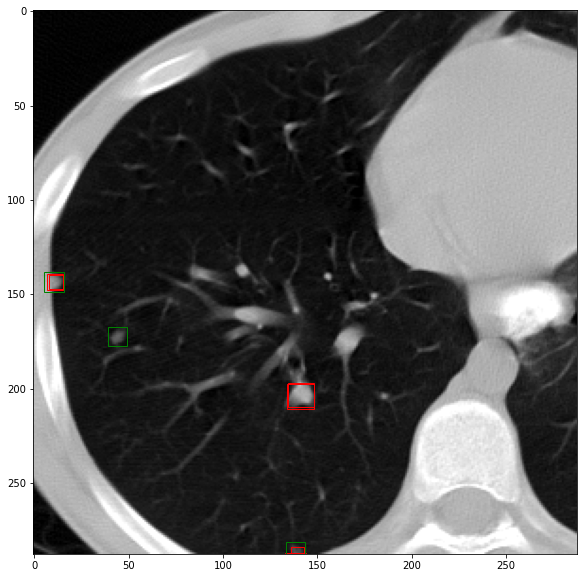

In [45]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

